In [2]:
%load_ext autoreload
%autoreload 2

from importers import SpikeImporter

data_folder = "../data/"
file_name = "11_10_27U2a_2000s_2300s_20000Hz_Force_AllFibres"
file_ending = ".csv"

time_channel = "Time"
signal_channel = "1 Signal"
stimulus_channel = "32 DigMark"
ap_marker_channels = ["801 nw-1", "12 nw-1", "14 nw-1"]
force_channel = "3 Force"
# extra_stimuli_channel = "801 DigMark"

# load the animal file
importer = SpikeImporter(filepath = data_folder + file_name + file_ending, time_channel = time_channel, signal_channel = signal_channel)

print("Data loaded.")

# define the max. time so that two sequential waveform-values are belonging to the same AP
# the time is in seconds, so 0.005 equals 5ms
max_gap_time = 0.005
force_thresh = 0.5

# retrieve the events from the importer 
el_stimuli = importer.get_electrical_stimuli(regular_stimulus_channel = stimulus_channel)
# ex_stimuli = importer.get_extra_stimuli(extra_stimulus_channel = extra_stimuli_channel, regular_el_stimuli = el_stimuli)
mech_stimuli = importer.get_mechanical_stimuli(force_channel = force_channel, threshold = force_thresh, max_gap_time = 0.005)
actpots = importer.get_action_potentials(max_gap_time = max_gap_time, ap_marker_channels = ap_marker_channels, \
                                       el_stimuli = el_stimuli, mech_stimuli = mech_stimuli)
raw_signal = importer.get_raw_signal_split_by_stimuli(el_stimuli = el_stimuli, verbose = False)

Data loaded.
List of eletrical stimuli created.
List of mechanical stimuli created.
Finished processing AP channel 1 out of 3
Finished processing AP channel 2 out of 3
Finished processing AP channel 3 out of 3
List of APs created.
Done with cropping the intervals


In [3]:
''' 
This cell performs the clustering according to
- distance to previous stimulus
- normalized signal energy of the APs
'''
%autoreload 2
from fibre_tracking import DBSCANClustering
from plotting import ClusterPlot2D

clustered_data_df = DBSCANClustering.perform_clustering(actpots, eps = 0.001, min_samples = 10, save_fibre_prediction = True)
cl2dplot = ClusterPlot2D()
cl2dplot.plot(clustered_data_df = clustered_data_df)

In [5]:
%autoreload 2
from plotting import FallingLeafPlot
from ipywidgets import interact_manual, interactive, fixed, IntSlider, FloatSlider

tmin, tmax = importer.get_time_range()
max_interval_length = max([stim.get_interval_length() for stim in el_stimuli])

flplot = FallingLeafPlot()
interact_manual(flplot.plot, regular_stimuli = fixed(el_stimuli), action_potentials = fixed(actpots), \
                t_start = FloatSlider(min = tmin, max = tmax, value = 0), \
                num_intervals = IntSlider(min = 1, max = 50, step = 1, value = 5), \
                post_stimulus_timeframe = FloatSlider(min = 0, max = max_interval_length, value = 0.1), \
                manual_name = "Update Plot")

interactive(children=(FloatSlider(value=0.0, description='t_start', max=300.0), IntSlider(value=5, description…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

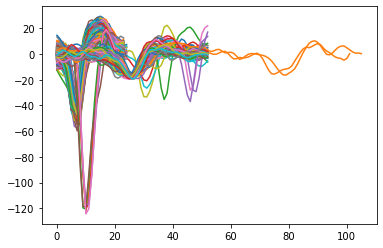

avg. len: 26 avg argmax: 16


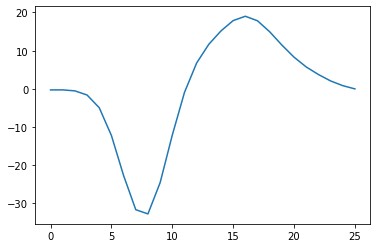

In [8]:
%autoreload 2
from fibre_tracking import ActionPotentialTemplate

# get the APs for a certain cluster number
cluster_idcs = [0]
filtered_aps = list(filter(lambda ap: ap.get_implied_fibre_index() in cluster_idcs, actpots))

fibre0_template = ActionPotentialTemplate.from_ap_list(aps = filtered_aps)

minimum correlation: 0.07445933214214176 at 1406
maximum correlation: 0.9950528706272825 at 805


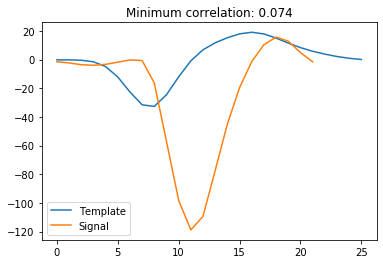

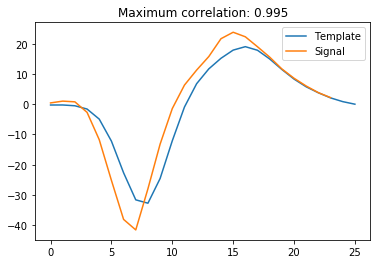

In [110]:
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from metrics import normalized_cross_correlation
    
template = fibre0_template.signal_template
corr = np.array([normalized_cross_correlation(template, ap.raw_signal) for ap in actpots])
    
# print(actpots)
# print(corr)
    
min_cor = np.argmin(corr)
max_cor = np.argmax(corr)

print("minimum correlation: " + str(corr[min_cor]) + " at " + str(min_cor))
print("maximum correlation: " + str(corr[max_cor]) + " at " + str(max_cor))
    
plt.figure()
# plt.plot(corr)
plt.plot(fibre0_template.signal_template, label = "Template")
plt.plot(actpots[min_cor].raw_signal, label = "Signal")
plt.title("Minimum correlation: " + '{:.3f}'.format(corr[min_cor]))
plt.legend()
plt.show()

plt.figure()
# plt.plot(corr)
plt.plot(fibre0_template.signal_template, label = "Template")
plt.plot(actpots[max_cor].raw_signal, label = "Signal")
plt.title("Maximum correlation: " + '{:.3f}'.format(corr[max_cor]))
plt.legend()
plt.show()

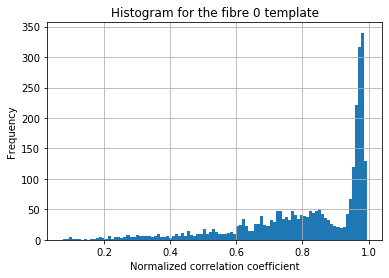

In [111]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(x = corr, bins = 100)
plt.grid(axis = 'both')
plt.xlabel("Normalized correlation coefficient")
plt.ylabel("Frequency")
plt.title("Histogram for the fibre 0 template")
plt.show()

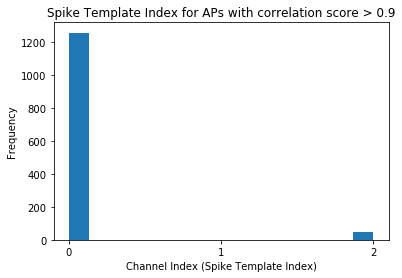

In [112]:
cor_thresh = 0.9

high_scoring = [ap for ap, cor in zip(actpots, corr) if cor > cor_thresh]

plt.figure()
plt.hist(x = [ap.channel_index for ap in high_scoring], bins = len(ap_marker_channels) * 5, align = "mid")
plt.xticks(list(range(0, len(ap_marker_channels))))
plt.xlabel("Channel Index (Spike Template Index)")
plt.ylabel("Frequency")
plt.title("Spike Template Index for APs with correlation score > " + str(cor_thresh))
plt.show()

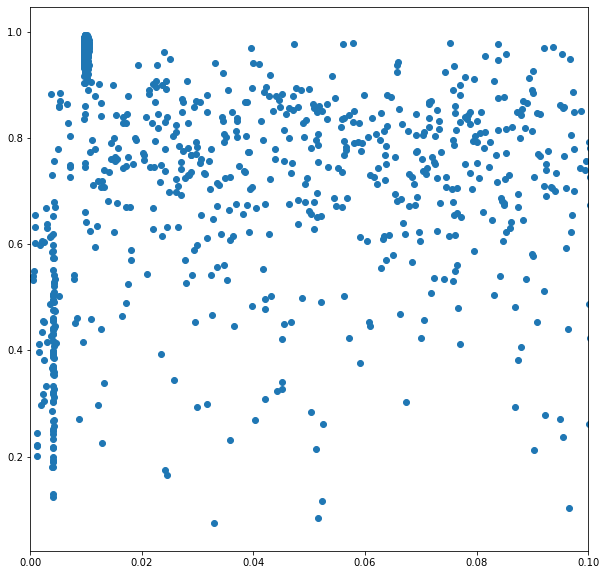

In [117]:
# draw a scatter plot with dimensions: correlation to fibre 0, latency
plt.figure(figsize = (10, 10))
plt.scatter(x = [ap.get_dist_to_prev_reg_el_stimulus() for ap in actpots], y = [corr])
plt.xlim(0, 0.1)
plt.show()